# Model Training and Evaluation

This notebook loads the preprocessed shot data, trains several xG models (with and without geometry features), and evaluates them against actual goals and the StatsBomb xG values.

## Imports

In [25]:
import pandas as pd
import numpy as np
from pathlib import Path

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score, brier_score_loss

from xgboost import XGBClassifier

import matplotlib.pyplot as plt


## Load preprocessed shots

In [27]:
# world cup 2018 data frame
data_path = Path("shots_featured_wc2018.csv")
shots_featured = pd.read_csv(data_path)
display(shots_featured.head())

# Euro 2020 data frame

eu_data_path = Path("shots_featured_eu2020.csv")
shots_eu = pd.read_csv(eu_data_path)
shots_eu.head()


,shot_statsbomb_xg,shot_type_id,shot_technique_id,shot_body_part_id,shot_open_goal,shot_first_time,shot_one_on_one,shot_aerial_won,x,y,is_goal,distance,angle
0,0.009816,62.0,93.0,40.0,0,0,0,0,115.0,18.0,0,22.561028,0.064071
1,0.038204,87.0,93.0,40.0,0,0,0,0,112.0,54.0,0,16.124515,0.202196
2,0.045128,87.0,93.0,40.0,0,0,0,0,98.0,37.0,0,22.203603,0.283785
3,0.625074,87.0,93.0,37.0,1,0,0,0,119.0,36.0,0,4.123106,0.758049
4,0.021760,87.0,93.0,40.0,0,0,0,0,97.0,56.0,0,28.017851,0.187756


,shot_statsbomb_xg,shot_type_id,shot_technique_id,shot_body_part_id,shot_open_goal,shot_first_time,shot_one_on_one,shot_aerial_won,x,y,is_goal,distance,angle
0,0.030169,87.0,93.0,38.0,0,0,0,0,91.9,39.0,0,28.117788,0.226500
1,0.021315,87.0,91.0,38.0,0,1,0,0,96.5,29.7,0,25.658137,0.228027
2,0.047888,62.0,93.0,40.0,0,0,0,0,97.8,25.9,0,26.299240,0.205564
3,0.100356,87.0,93.0,37.0,0,0,0,0,112.0,40.7,0,8.030567,0.756483
4,0.008758,87.0,93.0,38.0,0,0,0,0,99.7,58.6,0,27.532708,0.172017


## Define target and feature sets

We keep `shot_statsbomb_xg` and `is_goal` for evaluation. We build two feature matrices:

- **Raw features** (`X_raw`): all features *except* distance and angle (this mimics your early models).
- **Featured geometry** (`X_feat`): all features including distance and angle.

In [23]:
# Target
y = shots_featured["is_goal"].astype(int) # world cup data target
y_eu = shots_eu["is_goal"] # Euro data target 
# Base feature set (drop labels/statsbomb xg)
X_full = shots_featured.drop(["shot_statsbomb_xg", "is_goal"], axis=1)

X_full_eu = shots_eu.drop(["shot_statsbomb_xg","is_goal"],axis=1)

# Raw features: no distance & angle
drop_geom = [col for col in ["distance", "angle"] if col in X_full.columns]
X_raw = X_full.drop(drop_geom, axis=1)

X_raw_eu = X_full_eu.drop(["distance","angle"],axis=1)

# Featured geometry = all features
X_feat = X_full.copy()

X_feat_eu = X_full_eu

display(X_raw.head(), X_feat.head(), X_raw_eu.head(), X_feat_eu.head())


,shot_type_id,shot_technique_id,shot_body_part_id,shot_open_goal,shot_first_time,shot_one_on_one,shot_aerial_won,x,y
0,62.0,93.0,40.0,0,0,0,0,115.0,18.0
1,87.0,93.0,40.0,0,0,0,0,112.0,54.0
2,87.0,93.0,40.0,0,0,0,0,98.0,37.0
3,87.0,93.0,37.0,1,0,0,0,119.0,36.0
4,87.0,93.0,40.0,0,0,0,0,97.0,56.0


,shot_type_id,shot_technique_id,shot_body_part_id,shot_open_goal,shot_first_time,shot_one_on_one,shot_aerial_won,x,y,distance,angle
0,62.0,93.0,40.0,0,0,0,0,115.0,18.0,22.561028,0.064071
1,87.0,93.0,40.0,0,0,0,0,112.0,54.0,16.124515,0.202196
2,87.0,93.0,40.0,0,0,0,0,98.0,37.0,22.203603,0.283785
3,87.0,93.0,37.0,1,0,0,0,119.0,36.0,4.123106,0.758049
4,87.0,93.0,40.0,0,0,0,0,97.0,56.0,28.017851,0.187756


,shot_type_id,shot_technique_id,shot_body_part_id,shot_open_goal,shot_first_time,shot_one_on_one,shot_aerial_won,x,y
0,62.0,93.0,40.0,0,0,0,0,115.0,18.0
1,87.0,93.0,40.0,0,0,0,0,112.0,54.0
2,87.0,93.0,40.0,0,0,0,0,98.0,37.0
3,87.0,93.0,37.0,1,0,0,0,119.0,36.0
4,87.0,93.0,40.0,0,0,0,0,97.0,56.0


,shot_type_id,shot_technique_id,shot_body_part_id,shot_open_goal,shot_first_time,shot_one_on_one,shot_aerial_won,x,y,distance,angle
0,62.0,93.0,40.0,0,0,0,0,115.0,18.0,22.561028,0.064071
1,87.0,93.0,40.0,0,0,0,0,112.0,54.0,16.124515,0.202196
2,87.0,93.0,40.0,0,0,0,0,98.0,37.0,22.203603,0.283785
3,87.0,93.0,37.0,1,0,0,0,119.0,36.0,4.123106,0.758049
4,87.0,93.0,40.0,0,0,0,0,97.0,56.0,28.017851,0.187756


## Train/test split (shared indices)

We split once using `X_feat` and `y`, then use the resulting indices to build matching train/test sets for `X_raw`.


In [4]:
X_train_feat, X_test_feat, y_train, y_test = train_test_split(
    X_feat, y, test_size=0.2, random_state=42
)

# Align raw feature splits using the same indices
X_train_raw = X_raw.loc[X_train_feat.index]
X_test_raw = X_raw.loc[X_test_feat.index]

X_train_feat.shape, X_train_raw.shape, X_test_feat.shape, X_test_raw.shape


((1364, 11), (1364, 9), (342, 11), (342, 9))

## 1. Logistic Regression (raw features, no geometry)

Logistic regression model based on x, y and categorical/boolean features, without distance and angle.

In [5]:
lr_raw = LogisticRegression(max_iter=2000)
lr_raw.fit(X_train_raw, y_train)

lr_raw_pred_train = lr_raw.predict_proba(X_train_raw)[:, 1]
lr_raw_pred_test = lr_raw.predict_proba(X_test_raw)[:, 1]


## 2. XGBoost (raw features, no geometry)

XGBoost model that only used raw coordinates and simple features.

In [6]:
xgb_raw = XGBClassifier(
    n_estimators=300,
    learning_rate=0.05,
    max_depth=5,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    eval_metric="logloss",
)

xgb_raw.fit(X_train_raw, y_train)

xgb_raw_pred_train = xgb_raw.predict_proba(X_train_raw)[:, 1]
xgb_raw_pred_test = xgb_raw.predict_proba(X_test_raw)[:, 1]


## 3. Logistic Regression (featured geometry, unscaled)

Lr_featured model: distance and angle included, but no scaling.

In [7]:
lr_featured = LogisticRegression(max_iter=2000)
lr_featured.fit(X_train_feat, y_train)

lr_featured_pred_train = lr_featured.predict_proba(X_train_feat)[:, 1]
lr_featured_pred_test = lr_featured.predict_proba(X_test_feat)[:, 1]


## 4. XGBoost (featured geometry)

Xgb_featured model that uses distance and angle.

In [8]:
xgb_featured = XGBClassifier(
    n_estimators=300,
    learning_rate=0.05,
    max_depth=5,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    eval_metric="logloss",
)

xgb_featured.fit(X_train_feat, y_train)

xgb_featured_pred_train = xgb_featured.predict_proba(X_train_feat)[:, 1]
xgb_featured_pred_test = xgb_featured.predict_proba(X_test_feat)[:, 1]


## 5. Scaled Logistic Regression (featured geometry)

We standardize all features and then fit logistic regression. This corresponds to the `lr_scaled` model.

In [9]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_feat)
X_test_scaled = scaler.transform(X_test_feat)

lr_scaled = LogisticRegression(max_iter=2000)
lr_scaled.fit(X_train_scaled, y_train)

lr_scaled_pred_train = lr_scaled.predict_proba(X_train_scaled)[:, 1]
lr_scaled_pred_test = lr_scaled.predict_proba(X_test_scaled)[:, 1]


## Build comparison dataframe (test set)

We collect StatsBomb xG, actual goals, and predictions from all five models.

In [10]:
comparison_df = pd.DataFrame({
    "shot_statsbomb_xg": shots_featured.loc[X_test_feat.index, "shot_statsbomb_xg"].values,
    "is_goal": y_test.values,
    "lr_raw": lr_raw_pred_test,
    "xgb_raw": xgb_raw_pred_test,
    "lr_featured": lr_featured_pred_test,
    "xgb_featured": xgb_featured_pred_test,
    "lr_scaled": lr_scaled_pred_test,
})

comparison_df.head()


,shot_statsbomb_xg,is_goal,lr_raw,xgb_raw,lr_featured,xgb_featured,lr_scaled
0,0.078730,0,0.049262,0.031553,0.069649,0.040645,0.069209
1,0.007215,0,0.126591,0.041333,0.011108,0.011772,0.013216
2,0.783500,1,0.141727,0.783276,0.226642,0.770957,0.219267
3,0.087583,0,0.077211,0.017268,0.045591,0.007649,0.035797
4,0.025096,0,0.063974,0.015529,0.035592,0.030443,0.037155


## Summary statistics

In [11]:
comparison_df.describe()


,shot_statsbomb_xg,is_goal,lr_raw,xgb_raw,lr_featured,xgb_featured,lr_scaled
count,342.000000,342.000000,342.000000,342.000000,342.000000,342.000000,342.000000
mean,0.118388,0.105263,0.102241,0.107571,0.104983,0.097891,0.104731
std,0.180723,0.307342,0.077008,0.175386,0.107801,0.172091,0.110834
min,0.002964,0.000000,0.001087,0.000749,0.001304,0.000505,0.001779
25%,0.025876,0.000000,0.045255,0.014487,0.031462,0.009792,0.032778
50%,0.059337,0.000000,0.076766,0.036058,0.068940,0.030778,0.064783
75%,0.115843,0.000000,0.141870,0.102246,0.145487,0.084429,0.141356
max,0.991865,1.000000,0.510550,0.827080,0.651255,0.866091,0.729752


## Total xG vs actual goals

In [12]:
print("Actual goals (test):", comparison_df["is_goal"].sum())
print("StatsBomb total xG (test):", comparison_df["shot_statsbomb_xg"].sum())
print("LR raw total xG (test):", comparison_df["lr_raw"].sum())
print("XGB raw total xG (test):", comparison_df["xgb_raw"].sum())
print("LR featured total xG (test):", comparison_df["lr_featured"].sum())
print("XGB featured total xG (test):", comparison_df["xgb_featured"].sum())
print("LR scaled total xG (test):", comparison_df["lr_scaled"].sum())


Actual goals (test): 36
StatsBomb total xG (test): 40.488823539
LR raw total xG (test): 34.96657608222938
XGB raw total xG (test): 36.78942
LR featured total xG (test): 35.90419230392568
XGB featured total xG (test): 33.478592
LR scaled total xG (test): 35.81801619813396


## Correlation with StatsBomb xG

In [13]:
comparison_df[[
    "shot_statsbomb_xg",
    "lr_raw",
    "xgb_raw",
    "lr_featured",
    "xgb_featured",
    "lr_scaled",
]].corr()


,shot_statsbomb_xg,lr_raw,xgb_raw,lr_featured,xgb_featured,lr_scaled
shot_statsbomb_xg,1.000000,0.447874,0.798818,0.638006,0.826934,0.630348
lr_raw,0.447874,1.000000,0.397209,0.761816,0.400639,0.767028
xgb_raw,0.798818,0.397209,1.000000,0.601778,0.927220,0.612150
lr_featured,0.638006,0.761816,0.601778,1.000000,0.596840,0.994141
xgb_featured,0.826934,0.400639,0.927220,0.596840,1.000000,0.606054
lr_scaled,0.630348,0.767028,0.612150,0.994141,0.606054,1.000000


## AUC and Brier scores vs actual goals

In [14]:
auc_lr_raw = roc_auc_score(comparison_df["is_goal"], comparison_df["lr_raw"])
auc_xgb_raw = roc_auc_score(comparison_df["is_goal"], comparison_df["xgb_raw"])
auc_lr_featured = roc_auc_score(comparison_df["is_goal"], comparison_df["lr_featured"])
auc_xgb_featured = roc_auc_score(comparison_df["is_goal"], comparison_df["xgb_featured"])
auc_lr_scaled = roc_auc_score(comparison_df["is_goal"], comparison_df["lr_scaled"])

brier_lr_raw = brier_score_loss(comparison_df["is_goal"], comparison_df["lr_raw"])
brier_xgb_raw = brier_score_loss(comparison_df["is_goal"], comparison_df["xgb_raw"])
brier_lr_featured = brier_score_loss(comparison_df["is_goal"], comparison_df["lr_featured"])
brier_xgb_featured = brier_score_loss(comparison_df["is_goal"], comparison_df["xgb_featured"])
brier_lr_scaled = brier_score_loss(comparison_df["is_goal"], comparison_df["lr_scaled"])

print("=== AUC ===")
print("LR raw:       ", auc_lr_raw)
print("XGB raw:      ", auc_xgb_raw)
print("LR featured:  ", auc_lr_featured)
print("XGB featured: ", auc_xgb_featured)
print("LR scaled:    ", auc_lr_scaled)

print("\n=== Brier ===")
print("LR raw:       ", brier_lr_raw)
print("XGB raw:      ", brier_xgb_raw)
print("LR featured:  ", brier_lr_featured)
print("XGB featured: ", brier_xgb_featured)
print("LR scaled:    ", brier_lr_scaled)


=== AUC ===
LR raw:        0.7207697893972403
XGB raw:       0.7949346405228758
LR featured:   0.7942992011619463
XGB featured:  0.7893064633260711
LR scaled:     0.7951161946259986

=== Brier ===
LR raw:        0.0881982269244545
XGB raw:       0.07956310861461073
LR featured:   0.08050550091231719
XGB featured:  0.07708246772336283
LR scaled:     0.08053576190678577


## Scatterplots vs StatsBomb xG

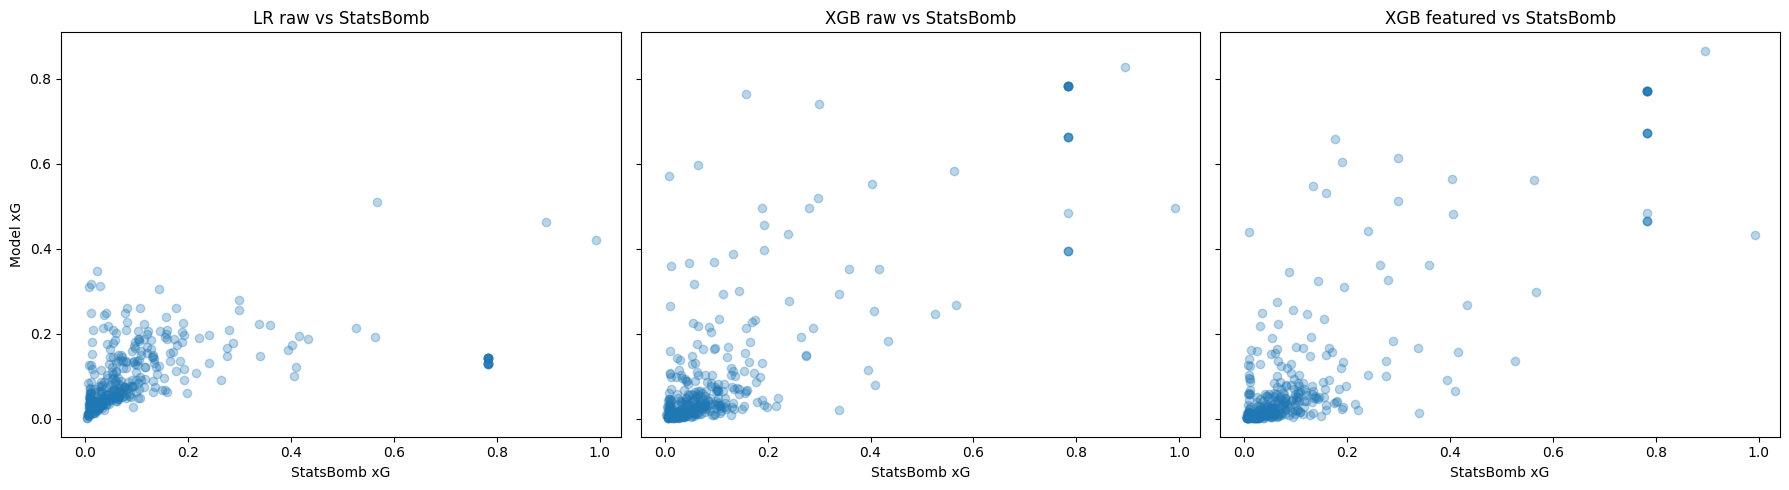

In [15]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5), sharex=True, sharey=True)

axes[0].scatter(comparison_df["shot_statsbomb_xg"], comparison_df["lr_raw"], alpha=0.3)
axes[0].set_title("LR raw vs StatsBomb")
axes[0].set_xlabel("StatsBomb xG")
axes[0].set_ylabel("Model xG")

axes[1].scatter(comparison_df["shot_statsbomb_xg"], comparison_df["xgb_raw"], alpha=0.3)
axes[1].set_title("XGB raw vs StatsBomb")
axes[1].set_xlabel("StatsBomb xG")

axes[2].scatter(comparison_df["shot_statsbomb_xg"], comparison_df["xgb_featured"], alpha=0.3)
axes[2].set_title("XGB featured vs StatsBomb")
axes[2].set_xlabel("StatsBomb xG")

plt.tight_layout()
plt.show()


## (Optional) Save models to disk


In [16]:
# import joblib
# joblib.dump(lr_raw, "lr_raw_wc2018.pkl")
# joblib.dump(xgb_raw, "xgb_raw_wc2018.pkl")
# joblib.dump(lr_featured, "lr_featured_wc2018.pkl")
# joblib.dump(xgb_featured, "xgb_featured_wc2018.pkl")
# joblib.dump(lr_scaled, "lr_scaled_wc2018.pkl")
# joblib.dump(scaler, "scaler_wc2018.pkl")
# print("Saved models and scaler to disk.")
